In [1]:
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from catboost import Pool, CatBoostRegressor
pd.set_option('display.max_columns', None)
print('available GPU devices:', len(os.environ['CUDA_VISIBLE_DEVICES']), 
      ' | device num:', os.environ['CUDA_VISIBLE_DEVICES'])
from catboost.utils import get_gpu_device_count
from tqdm.notebook import tqdm
print('available GPU devices catboost:', get_gpu_device_count())

available GPU devices: 1  | device num: 0
available GPU devices catboost: 1


In [2]:
DATA_DIR = './data'
MODELS_DIR = './models'
MODEL_VER = 'v0'
BACKWARD_LAGS = 60
CUT_DATE = '2014-01-01'
VAL_DATE = '2016-04-01'
END_DATE = '2016-04-24'
print(datetime.strptime(END_DATE, '%Y-%m-%d'))
#-----|CUT_DATE|---train---|VAL_DATE|--val--|END_DATE|--forecast +28 days-->

2016-04-24 00:00:00


In [3]:
CALENDAR_DTYPES = {
    'date':             'str',
    'wm_yr_wk':         'int16', 
    'weekday':          'object',
    'wday':             'int16', 
    'month':            'int16', 
    'year':             'int16', 
    'd':                'object',
    'event_name_1':     'object',
    'event_type_1':     'object',
    'event_name_2':     'object',
    'event_type_2':     'object',
    'snap_CA':          'int16', 
    'snap_TX':          'int16', 
    'snap_WI':          'int16'
}
PARSE_DATES = ['date']
SPRICES_DTYPES = {
    'store_id':    'object', 
    'item_id':     'object', 
    'wm_yr_wk':    'int16',  
    'sell_price':  'float32'
}

In [4]:
def get_df(is_train=True, backward_lags=None):
    strain = pd.read_csv('{}/sales_train_validation.csv'.format(DATA_DIR))
    print('read train:', strain.shape)
    cat_cols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    last_day = int(strain.columns[-1].replace('d_', ''))
    print('last day is:', last_day)
    if not is_train:
        for day in range(last_day + 1, last_day + 28 + 28 + 1):
            strain['d_{}'.format(day)] = np.nan
    strain = pd.melt(
        strain,
        id_vars = cat_cols,
        value_vars = [col for col in strain.columns if col.startswith('d_')],
        var_name = 'd',
        value_name = 'sales'
    )
    print('melted train:', strain.shape)
    calendar = pd.read_csv('{}/calendar.csv'.format(DATA_DIR), dtype=CALENDAR_DTYPES, parse_dates=PARSE_DATES)
    print('read calendar:', calendar.shape)
    strain = strain.merge(calendar, on='d', copy=False)
    print('calendar merge done')
    sprices = pd.read_csv('{}/sell_prices.csv'.format(DATA_DIR), dtype=SPRICES_DTYPES)
    print('read prices:', sprices.shape)
    strain = strain.merge(
        sprices, 
        on=['store_id', 'item_id', 'wm_yr_wk'], 
        copy=False
    )
    print('prices merge done')
    print('begin train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    if not is_train:
        strain = strain.loc[
            strain['date'] >= (datetime.strptime(END_DATE, '%Y-%m-%d') - timedelta(days=backward_lags))
        ]
    else:
        strain = strain.loc[strain['date'] >= CUT_DATE]
    print('date cut train:', strain.shape)
    print('cut train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    return strain

In [5]:
def make_features(strain):
    print('in dataframe:', strain.shape)
    lags = [7, 28]
    windows= [7, 28]
    wnd_feats = [
        'id', 
        'item_id', 
        #'dept_id', 
        'store_id', 
        'cat_id', 
        #'state_id'
    ]
    lag_cols = ['lag_{}'.format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        strain[lag_col] = strain[['id', 'sales']].groupby('id')['sales'].shift(lag)
    print('lag sales done')
    for wnd_feat in wnd_feats:
        for wnd in windows:
            for lag_col in lag_cols:
                wnd_col = '{}_{}_rmean_{}'.format(lag_col, wnd_feat, wnd)
                strain[wnd_col] = strain[[wnd_feat, lag_col]].groupby(wnd_feat)[lag_col].transform(
                    lambda x: x.rolling(wnd).mean()
                )
        print('rolling mean sales for feature done:', wnd_feat)
    date_features = {
        'week_num': 'weekofyear',
        'quarter': 'quarter',
        'mday': 'day'
    }
    for date_feat_name, date_feat_func in date_features.items():
        strain[date_feat_name] = getattr(strain['date'].dt, date_feat_func).astype('int16')
    print('date features done')
    strain['d'] = strain['d'].apply(lambda x: int(x.replace('d_', '')))  
    print('out dataframe:', strain.shape)
    return strain

In [6]:
%%time
strain = get_df(is_train=True, backward_lags=None)

read train: (30490, 1919)
last day is: 1913
melted train: (58327370, 8)
read calendar: (1969, 14)
calendar merge done
read prices: (6841121, 4)
prices merge done
begin train date: 2011-01-29 00:00:00
end train date: 2016-04-24 00:00:00
date cut train: (24825039, 22)
cut train date: 2014-01-01 00:00:00
end train date: 2016-04-24 00:00:00
CPU times: user 37.8 s, sys: 6.32 s, total: 44.1 s
Wall time: 44.1 s


In [7]:
%%time
strain = make_features(strain)

in dataframe: (24825039, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
rolling mean sales for feature done: store_id
rolling mean sales for feature done: cat_id
date features done
out dataframe: (24825039, 43)
CPU times: user 1min 52s, sys: 10.9 s, total: 2min 3s
Wall time: 2min 3s


id to draw: HOBBIES_2_044_CA_4_validation
from 2014-01-01 00:00:00 to 2016-04-24 00:00:00


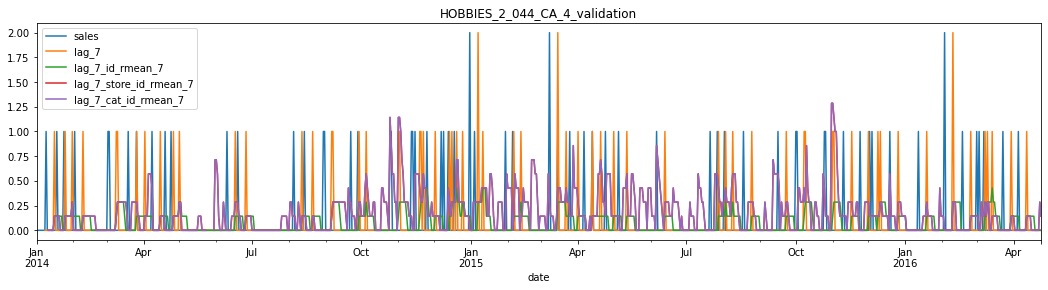

In [8]:
id_name = np.random.choice(strain['id'].unique())
print('id to draw:', id_name)
id_sales = strain.loc[strain['id'] == id_name].set_index('date')
print('from', strain['date'].min(), 'to', strain['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales['lag_7'].plot(label='lag_7')
id_sales['lag_7_id_rmean_7'].plot(label='lag_7_id_rmean_7')
try:
    id_sales['lag_7_store_id_rmean_7'].plot(label='lag_7_store_id_rmean_7')
    id_sales['lag_7_cat_id_rmean_7'].plot(label='lag_7_cat_id_rmean_7')
except:
    print('no features')
    pass
plt.title(id_name)
plt.legend()
plt.show()

In [9]:
drop_cols = ['id', 'sales', 'date', 'wm_yr_wk', 'weekday']
train_cols = strain.columns[~strain.columns.isin(drop_cols)]
cat_cols = [
    'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 
    #'year', 'wday', 'month', 'quarter',
    'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
    #'snap_CA', 'snap_TX', 'snap_WI'
]
strain[cat_cols] = strain[cat_cols].fillna(0)

In [10]:
%%time
if False: #True if last period as validation
    X_train = strain[strain['date'] <= VAL_DATE][train_cols]
    y_train = strain[strain['date'] <= VAL_DATE]['sales']
    X_val = strain[strain['date'] > VAL_DATE][train_cols]
    y_val = strain[strain['date'] > VAL_DATE]['sales']
else: #random sample for validation
    val_size = int(strain.shape[0] * .15)
    val_idxs = np.random.choice(strain.index.values, val_size, replace=False)
    train_idxs = np.setdiff1d(strain.index.values, val_idxs)
    X_train = strain.loc[train_idxs][train_cols]
    y_train = strain.loc[train_idxs]['sales']
    X_val = strain.loc[val_idxs][train_cols]
    y_val = strain.loc[val_idxs]['sales']
print('train shapes:', X_train.shape, len(y_train))
print('val shapes:', X_val.shape, len(y_val))
train_pool = Pool(
    X_train, 
    y_train,
    cat_features=cat_cols
)
val_pool = Pool(
    X_val, 
    y_val,
    cat_features=cat_cols
)

train shapes: (21101284, 38) 21101284
val shapes: (3723755, 38) 3723755
CPU times: user 58.5 s, sys: 3.47 s, total: 1min 1s
Wall time: 48.8 s


In [11]:
del X_train, y_train, X_val, y_val, val_idxs, train_idxs, val_size
gc.collect()

4758

In [12]:
model = CatBoostRegressor(
    iterations=1000,
    task_type='GPU', #'CPU'
    verbose=0,
    loss_function='RMSE',
    boosting_type='Plain',
    depth=6,
    gpu_cat_features_storage='CpuPinnedMemory',
    #max_ctr_complexity=2
)
model.fit(
    train_pool,
    eval_set = val_pool,
    plot=True   
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [13]:
model.save_model('{}/model_{}.cbm'.format(MODELS_DIR, MODEL_VER))

In [14]:
model = CatBoostRegressor().load_model('{}/model_{}.cbm'.format(MODELS_DIR, MODEL_VER))

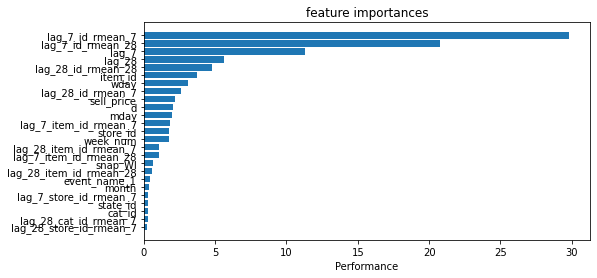

In [15]:
feat_importances = sorted(
    [(f, v) for f, v in zip(train_cols, model.get_feature_importance())],
    key=lambda x: x[1],
    reverse=True
)
threshold = .25
labels = [x[0] for x in feat_importances if x[1] > threshold]
values = [x[1] for x in feat_importances if x[1] > threshold]
fig, ax = plt.subplots(figsize=(8, 4))
y_pos = np.arange(len(labels))
ax.barh(y_pos, values)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel('Performance')
ax.set_title('feature importances')
plt.show()

In [16]:
spred = strain[strain['date'] >= VAL_DATE].copy()
preds = model.predict(spred[train_cols])
print('predictions done:', len(preds))
spred.loc[:, 'sales'] = preds

predictions done: 731760


id to draw: FOODS_3_248_CA_2_validation
from 2014-01-01 00:00:00 to 2016-04-24 00:00:00


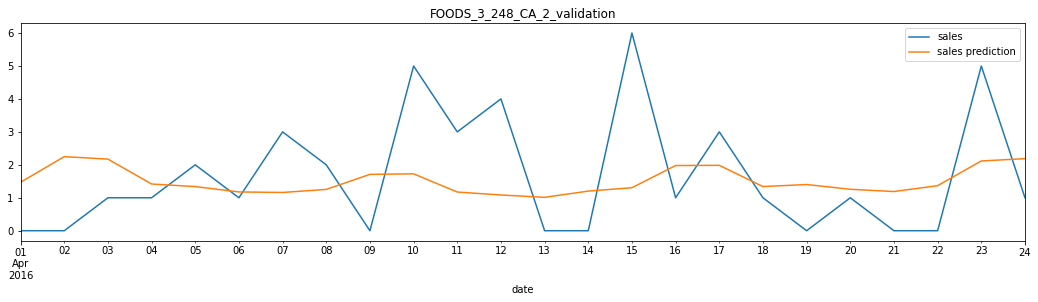

In [19]:
id_name = np.random.choice(strain['id'].unique())
print('id to draw:', id_name)
id_sales = strain.loc[(strain['id'] == id_name) & (strain['date'] >= VAL_DATE)].set_index('date')
id_sales_pred = spred.loc[spred['id'] == id_name].set_index('date')
print('from', strain['date'].min(), 'to', strain['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred['sales'].plot(label='sales prediction')
plt.title(id_name)
plt.legend()
plt.show()

In [20]:
%%time
growth_rate = 1
spred = get_df(is_train=False, backward_lags=BACKWARD_LAGS)
for pred_day in tqdm(range(1, 28 + 28 + 1)):
    pred_date = datetime.strptime(END_DATE, '%Y-%m-%d') + timedelta(days=pred_day)
    pred_date_back = pred_date - timedelta(days=BACKWARD_LAGS + 1)
    print('-' * 70)
    print('forecast day forward:', pred_day, '| forecast date:', pred_date) 
    spred_data = spred[(spred['date'] >= pred_date_back) & (spred['date'] <= pred_date)].copy()
    spred_data = make_features(spred_data)
    spred_data = spred_data.loc[spred['date'] == pred_date, train_cols]
    spred_data[cat_cols] = spred_data[cat_cols].fillna(0)
    spred.loc[spred['date'] == pred_date, 'sales'] = growth_rate * model.predict(spred_data)

read train: (30490, 1919)
last day is: 1913
melted train: (60034810, 8)
read calendar: (1969, 14)
calendar merge done
read prices: (6841121, 4)
prices merge done
begin train date: 2011-01-29 00:00:00
end train date: 2016-06-19 00:00:00
date cut train: (3567330, 22)
cut train date: 2016-02-24 00:00:00
end train date: 2016-06-19 00:00:00


----------------------------------------------------------------------
forecast day forward: 1 | forecast date: 2016-04-25 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
rolling mean sales for feature done: store_id
rolling mean sales for feature done: cat_id
date features done
out dataframe: (1890380, 43)
----------------------------------------------------------------------
forecast day forward: 2 | forecast date: 2016-04-26 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
rolling mean sales for feature done: store_id
rolling mean sales for feature done: cat_id
date features done
out dataframe: (1890380, 43)
----------------------------------------------------------------------
forecast day forward: 3 | forecast date: 2016-04-27 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for featur

rolling mean sales for feature done: store_id
rolling mean sales for feature done: cat_id
date features done
out dataframe: (1890380, 43)
----------------------------------------------------------------------
forecast day forward: 22 | forecast date: 2016-05-16 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
rolling mean sales for feature done: store_id
rolling mean sales for feature done: cat_id
date features done
out dataframe: (1890380, 43)
----------------------------------------------------------------------
forecast day forward: 23 | forecast date: 2016-05-17 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
rolling mean sales for feature done: store_id
rolling mean sales for feature done: cat_id
date features done
out dataframe: (1890380, 43)
----------------------------------------------------------------

in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
rolling mean sales for feature done: store_id
rolling mean sales for feature done: cat_id
date features done
out dataframe: (1890380, 43)
----------------------------------------------------------------------
forecast day forward: 43 | forecast date: 2016-06-06 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
rolling mean sales for feature done: store_id
rolling mean sales for feature done: cat_id
date features done
out dataframe: (1890380, 43)
----------------------------------------------------------------------
forecast day forward: 44 | forecast date: 2016-06-07 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
rolling mean sales for feature done: store_id
rolling mean sales for featu

id to draw: HOUSEHOLD_2_112_CA_3_validation
from 2014-01-01 00:00:00 to 2016-06-19 00:00:00


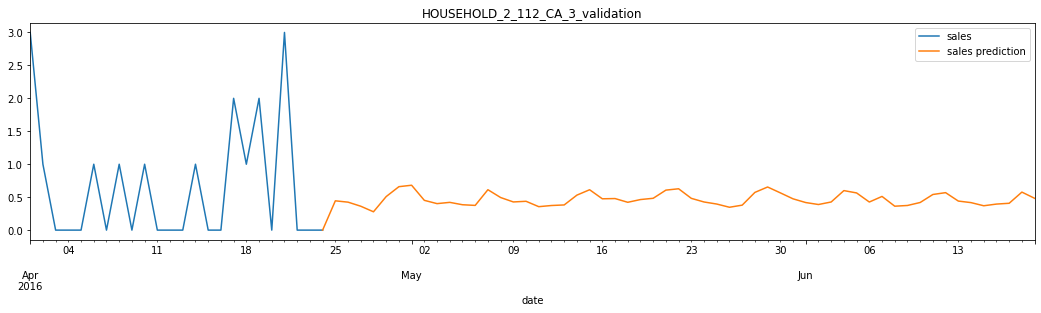

In [25]:
id_name = np.random.choice(strain['id'].unique())
print('id to draw:', id_name)
id_sales = strain.loc[(strain['id'] == id_name) & (strain['date'] >= VAL_DATE)].set_index('date')
id_sales_pred = spred.loc[(spred['id'] == id_name) & (spred['date'] >= END_DATE)].set_index('date')
print('from', strain['date'].min(), 'to', spred['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred['sales'].plot(label='sales prediction')
plt.title(id_name)
plt.legend()
plt.show()

In [22]:
spred_subm = spred.loc[spred['date'] > END_DATE, ['id', 'd', 'sales']].copy()
last_d = int(spred.loc[spred['date'] == END_DATE, 'd'].unique()[0].replace('d_', ''))
print('last d num:', last_d)
spred_subm['d'] = spred_subm['d'].apply(lambda x: 'F{}'.format(int(x.replace('d_', '')) - last_d))

last d num: 1913


,id,d,sales
45966979,HOBBIES_1_001_CA_1_validation,F1,0.749072
45966980,HOBBIES_1_001_CA_1_validation,F2,0.687828
45966981,HOBBIES_1_001_CA_1_validation,F3,0.648046
45966982,HOBBIES_1_001_CA_1_validation,F4,0.735294
45966983,HOBBIES_1_001_CA_1_validation,F5,0.720640


In [23]:
f_cols = ['F{}'.format(x) for x in range(1, 28 + 28 + 1)]
spred_subm = spred_subm.set_index(['id', 'd']).unstack()['sales'][f_cols].reset_index()
spred_subm.fillna(0, inplace=True)
spred_subm.where(spred_subm[f_cols] < 0, 0, inplace=True)
spred_subm.sort_values('id', inplace=True)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.head()

d,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30,F31,F32,F33,F34,F35,F36,F37,F38,F39,F40,F41,F42,F43,F44,F45,F46,F47,F48,F49,F50,F51,F52,F53,F54,F55,F56
0,FOODS_1_001_CA_1_validation,1.042026,0.830615,0.804250,0.793020,0.962978,1.122599,1.129432,0.970959,0.895474,1.011187,0.791034,0.936800,1.242012,1.161786,0.989597,0.948244,0.861277,0.873955,0.894576,1.212458,1.108655,0.896265,0.840352,0.774955,0.760284,0.807457,1.082325,1.122601,0.786612,0.786476,0.781158,0.775942,0.790924,1.086540,1.117205,0.858654,0.821491,0.860452,0.862053,0.961136,1.166493,1.147251,0.840212,0.878303,0.833641,0.865008,0.918001,1.102613,1.114417,0.811509,0.809542,0.811257,0.823089,0.863373,1.112818,1.041288
1,FOODS_1_001_CA_2_validation,1.052536,0.886137,0.888246,1.102542,1.107048,1.641793,1.943861,1.153317,1.012822,0.961509,0.861420,0.979278,1.286458,1.236485,1.012407,0.953222,1.007926,0.974548,0.977067,1.420063,2.139650,1.134693,1.085950,1.088256,1.198605,1.207563,1.449503,1.450887,1.045125,0.961917,1.019678,0.991483,1.046431,1.489996,1.389317,1.088280,1.022020,1.016735,1.043654,1.169128,1.382717,1.464568,1.077398,1.029670,1.095224,1.116165,1.080343,1.307065,1.425964,1.031108,1.041385,1.065116,0.976409,1.070605,1.287602,1.225183
2,FOODS_1_001_CA_3_validation,1.020622,0.932801,0.867125,0.917916,0.934048,1.103531,0.973110,0.787768,0.828614,0.789608,0.676187,0.806177,1.112692,1.109750,0.960048,0.922330,0.865075,0.866340,0.813969,1.033533,1.710132,1.024939,0.948065,0.890528,0.870456,0.880009,1.029096,0.719384,0.663386,0.744309,0.709459,0.733733,0.735548,1.041190,1.011356,0.823136,0.796630,0.786988,0.754908,0.878271,1.000333,1.085184,0.825847,0.817081,0.791026,0.840486,0.824408,0.950638,1.035898,0.730301,0.791416,0.778323,0.772503,0.792392,0.944636,0.961714
3,FOODS_1_001_CA_4_validation,0.388998,0.485883,0.347898,0.366892,0.482679,0.362072,0.386120,0.290548,0.330842,0.366512,0.358337,0.404745,0.395667,0.297466,0.338159,0.400282,0.374759,0.367313,0.363348,0.336711,0.369015,0.431905,0.395691,0.380979,0.387984,0.417611,0.422500,0.497143,0.374708,0.383747,0.382230,0.423517,0.437871,0.404288,0.405812,0.413023,0.390030,0.343760,0.367982,0.434469,0.384431,0.415305,0.356264,0.460644,0.366078,0.398474,0.457180,0.356882,0.411087,0.362963,0.376412,0.394261,0.407767,0.436214,0.362038,0.392658
4,FOODS_1_001_TX_1_validation,0.247454,0.230479,0.193665,0.214068,0.183722,0.234861,0.317585,0.216781,0.255104,0.236038,0.335187,0.301902,0.286155,0.256450,0.385772,0.308569,0.366720,0.369666,0.332039,0.397805,0.497766,0.335990,0.275640,0.246487,0.225078,0.233338,0.338742,0.372613,0.319167,0.339579,0.340620,0.316596,0.308905,0.279033,0.381269,0.385735,0.368736,0.362560,0.384168,0.446923,0.353091,0.469878,0.423960,0.430699,0.394640,0.462633,0.400639,0.461523,0.530832,0.431466,0.422225,0.516881,0.447410,0.419617,0.386658,0.409585


In [24]:
f_cols = ['F{}'.format(x) for x in range(1, 28 + 1)]
f_cols_eval = ['F{}'.format(x) for x in range(28 + 1, 28 + 28 + 1)]
spred_subm_eval = spred_subm.copy()
spred_subm.drop(columns=f_cols_eval, inplace=True)
spred_subm_eval.drop(columns=f_cols, inplace=True)
spred_subm_eval.columns = spred_subm.columns
spred_subm_eval['id'] = spred_subm_eval['id'].str.replace('validation', 'evaluation')
spred_subm = pd.concat([spred_subm, spred_subm_eval], axis=0, sort=False)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.to_csv('submission.csv', index=False)
print('submission saved:', spred_subm.shape)

submission saved: (60980, 29)


In [ ]:
%%time
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history = model.fit(X_train, y_train, 
                    epochs=300, 
                    batch_size=128, 
                    validation_data=(X_test, y_test), 
                    verbose=1,
                    callbacks=[earlystopper],
                    shuffle=False)